# Task 6 : 评估攻击识别的效果（多分类）
1. 使用COAP和SSPE方法计算Attack score，使用attack score的分布作为攻击的频谱
2. 使用Attack score做为标签，训练模型
3. 使用模型生成预测的Attack score
4. 对比不同攻击的attack score(攻击频谱)的相似度，识别攻击类型
5. 使用SSPE训练的模型，生成的频谱更稳定，可以有效识别攻击的类型
6. 这里只负责展现，数据处理由./common/IoTMLEvaluate.py完成

In [1]:
import os,json,sys,logging
sys.path.append("./share")
sys.path.append("./common")
import pandas as pd
import json
from tqdm.notebook import tqdm
from SHSample import CSHSample
from SHDataProcess import CSHDataProcess
from SHFeatureSelect import CSHFeature
from SHDataEDA import CSHDataDistribution,CSHDataTest
from SHEvaluation import CSHEvaluate,CSHROC,CSHSimilarity
from IoTMLEvaluate import CIoTAttack
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Config import g_data_root
from datetime import datetime
warnings.simplefilter("ignore")
pd.set_option('display.max_rows', 500)
g_token_root = "%stoken/"%g_data_root
g_feature_root = "%s/features"%g_data_root
g_result_root = "%sresult"%g_data_root

In [23]:
def show_bar(df_tmp):
    fig, axes = plt.subplots(1, 1, figsize=(9, 4))
    sns.barplot(x='accuracy', y='attack',hue='kind',orient='h',ci=None,data=df_tmp,ax=axes)
    axes.set_title("Accuracy")
    axes.set_xlabel('Accuracy', fontsize=10)
    axes.set_ylabel('Attack', fontsize=10)
    axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    #axes.set_xticklabels(axes.get_xticklabels(), rotation=20)
    plt.tight_layout()
    plt.show()
    
def show_line(df_tmp):
    fig, axes = plt.subplots(1, 1, figsize=(9, 4))
    sns.lineplot(x='ratio', y='accuracy',hue='kind',ci=None,data=df_tmp,ax=axes)
    axes.set_title("Accuracy")
    axes.set_xlabel('Noise ratio', fontsize=10)
    axes.set_ylabel('Accuracy', fontsize=10)
    axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    
    plt.tight_layout()
    plt.show()

# 计算相似度

In [4]:
df_score = pd.read_csv("./IIoTSet/result/ML-performance/task-6/regression-100.csv",index_col=0)
df_distance = pd.read_csv("./IIoTSet/result/ML-performance/task-6/distance-100.csv")
df_data = df_distance #df_distance[df_distance['n_sample']==0]

# 使用Cosine距离度量相似度

In [19]:
df_attack = CIoTAttack(df_score).get_attack(df_data,"Cosine")
df_result = CIoTAttack(df_score).get_accuracy(df_attack)
df_result['kind']=df_result['kind'].map({"score":"SSPE","sum":"COAP"})

100%|██████████| 141400/141400 [00:09<00:00, 14680.81it/s]


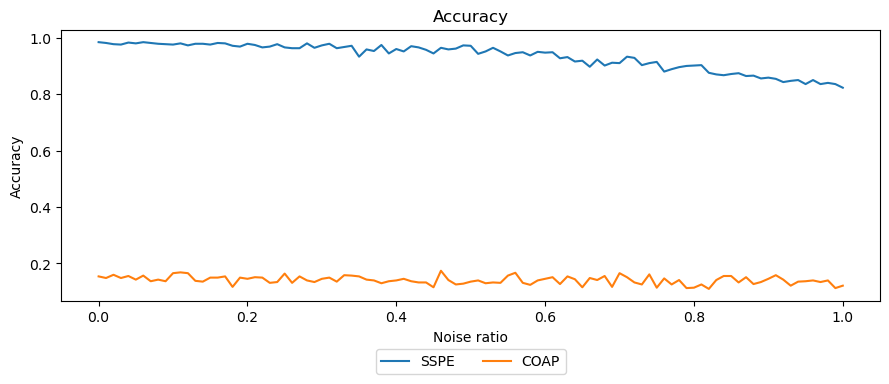

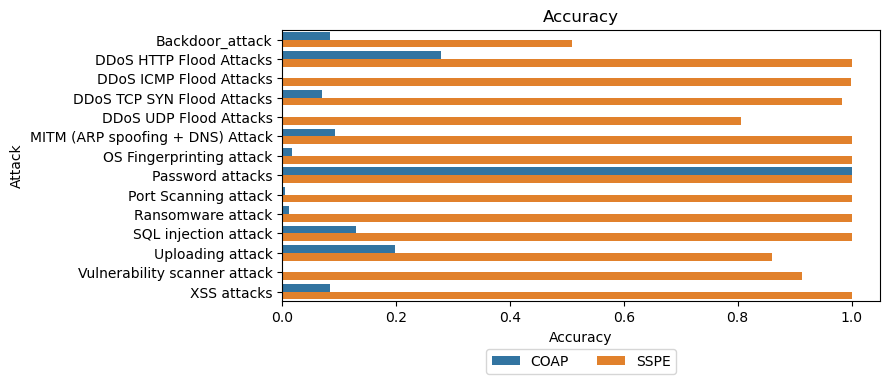

In [24]:
show_line(df_result)
df_tmp = df_result[['kind','ratio','attack','accuracy']].groupby(["kind",'attack']).mean().reset_index()
show_bar(df_tmp)

# 使用多种距离度量相似度

In [42]:
df_measure = pd.DataFrame()
for measure in ['Cosine','Pearson','Jaccard','KS','Euclidean','EMD','Manhattan','Minkowski']:
    df_attack = CIoTAttack(df_score).get_attack(df_data,measure)
    df_tmp = CIoTAttack(df_score).get_accuracy(df_attack)
    df_tmp['measure'] = measure
    df_measure = pd.concat([df_measure,df_tmp],ignore_index=True)
df_measure = df_measure.reset_index(drop=True) 

100%|██████████| 141400/141400 [00:10<00:00, 13565.08it/s]


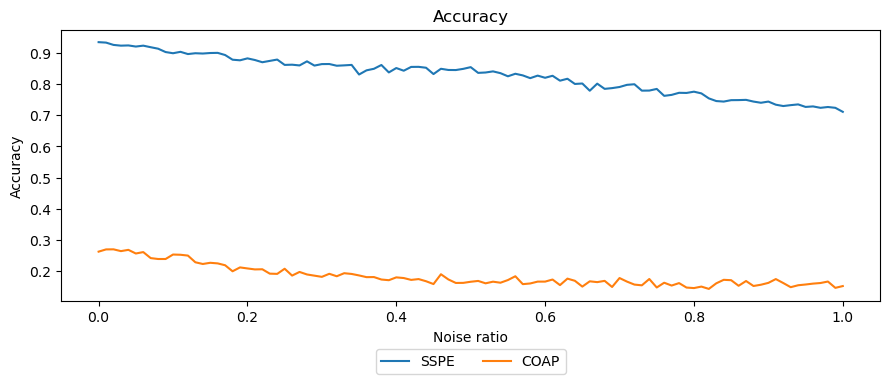

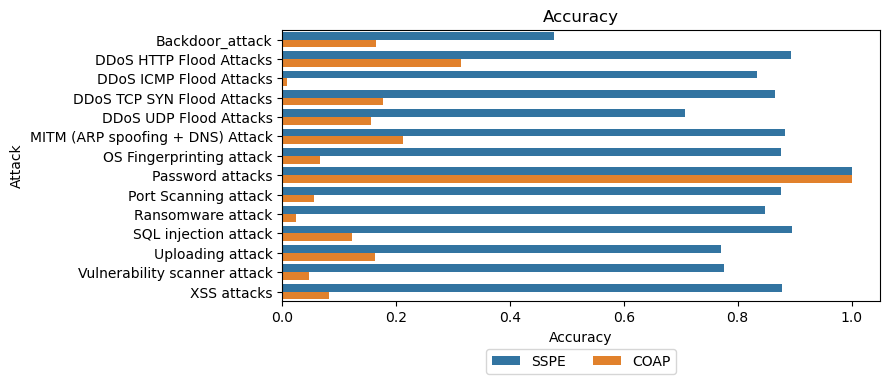

accuracy
measure   kind           
Cosine    COAP 0.14110325
          SSPE 0.93359264
EMD       COAP 0.37280057
          SSPE 0.36902405
Euclidean COAP 0.14110325
          SSPE 0.93359264
Manhattan COAP 0.22241867
          SSPE 0.87207921
Minkowski COAP 0.09257426
          SSPE 0.92124470
Pearson   COAP 0.14110325
          SSPE 0.93359264

In [43]:
df_tmp = df_measure.copy(deep=True)
df_tmp['kind']=df_tmp['kind'].map({"score":"SSPE","sum":"COAP"})

df_tmp = df_tmp[df_tmp['measure'] != "KS"]
df_tmp = df_tmp[df_tmp['measure'] != "Jaccard"]
df_tmp = df_tmp[df_tmp['measure'] != "Minkowski"]

show_line(df_tmp)
show_bar(df_tmp)

df_tmp[['measure','kind','accuracy']].groupby(['measure',"kind"]).mean()